In [1]:
import os,sys

In [ ]:
os.chdir("~/2025.LifeScienceAlliance/02.ML_Oligo_diff")

## I.Import packages

In [3]:
from __future__ import division
import scanpy as sc
import pandas as pd
import numpy as np
from backspinpy import SPIN, backSPIN, feature_selection, CEF_obj, Cef_tools#, cef2df
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict
from matplotlib import pyplot as mp
import pickle
import scipy
from scipy.io import mmread
import seaborn as sns
np.random.seed(123)
%matplotlib inline
import matplotlib

In [4]:
import math

## II. Load human developmental scRNA seq data with oligodendrocyte prototypes

In [ ]:
# Load proto data
adata = sc.read_h5ad("01.proto_select/scRNA_Merged_4data_Ols.h5ad")
df_dev = pd.DataFrame(adata.raw.X.T.A, index=adata.raw.var["_index"], columns=adata.raw.obs_names)
cols_oligo_all = adata.obs[['AgeGroup_5']].T

In [6]:
cols_oligo_proto = cols_oligo_all.copy()
cols_oligo_proto.loc['Prototype'] = ''

In [7]:
del adata

In [ ]:
### 1.1 Preprocess data, mask blood, mitochondrial and cell cycle genes
blood_genes = ['HBG1','HBA1','HBA2','HBE1','HBZ','BLVRB','S100A6']
mito_genes = open(r'~/2025.LifeScienceAlliance/02.ML_Oligo_diff/MitoGenes.txt').read().split("\t")
df_dev = df_dev.loc[~np.in1d(df_dev.index, blood_genes)&\
                        ~np.in1d(df_dev.index, mito_genes),:]#&\
                        #~np.in1d(df_dev.index, panther_cellcycle),:]

In [9]:
df_dev = df_dev.loc[:,(df_dev>0).sum(0)>0]
df_dev = df_dev.loc[(df_dev>0).sum(1)>0,:]

## III. Load MS oligodendrocyte data

In [ ]:
# Load MS data
adata = sc.read_h5ad("scRNA_MS_Oligo.h5ad")
#
df_MS_Oligo = pd.DataFrame(adata.raw.X.T.A, index=adata.raw.var["_index"], 
                           columns=adata.raw.obs_names)
#
cols_MS_all = adata.obs[['Lregion_sym']].T

In [11]:
del adata

In [12]:
df_MS_Oligo = df_MS_Oligo.loc[:,(df_MS_Oligo>0).sum(0)>0]
df_MS_Oligo = df_MS_Oligo.loc[(df_MS_Oligo>0).sum(1)>0,:]

In [13]:
# Annotation the prototypic cells
proto = pd.Series({'pre-OPC':'proto_PreOPC', 'dividing-OPC':'proto_DividingOPC',
                   'late-OPC':'proto_LateOPC', 'COP':'proto_COP',  
                   'NFOL':'proto_NFOL', 'MFOL':'proto_MFOL', 'MOL':'proto_MOL'})

proto_color = {'proto_PreOPC':(31, 119, 180),
               'proto_DividingOPC':(255, 127, 14),
               'proto_LateOPC':(44, 160, 44), 
               'proto_COP':(214, 39, 40), 
               'proto_NFOL':(148, 103, 189),
               'proto_MFOL':(140, 86, 75),
               'proto_MOL':(227, 119, 194)
}

## Extract the training dataset (From fetal to Adolescence)

In [14]:
df_proto = df_dev[cols_oligo_all.loc["AgeGroup_5"][cols_oligo_all.loc["AgeGroup_5"].isin({"Fetal", "Infancy", "Childhood", "Adolescence"})].index].copy()

## 1.2 Select the Pre-OPC, dividing OPC and later stage OPC prototypes

In [ ]:
# Choose preOPC marker expressed cells
df_preOPC = df_proto.loc[:,df_proto.loc[["EGFR"],:].sum(0)>0]
df_preOPC = df_preOPC.loc[:,df_preOPC.loc[["NES"],:].sum(0)>0]
df_preOPC = df_preOPC.loc[:,df_preOPC.loc[["ZFP36L1"],:].sum(0)>0]
df_preOPC = df_proto.loc[:,df_proto.loc[["GFAP"],:].sum(0)>0]

print("pre-OPC mount:",df_preOPC.shape)

pre-OPC mount: (45607, 2607)


In [16]:
for barcode in df_preOPC.columns:
    cols_oligo_proto.at['Prototype', barcode] = "pre-OPC"

In [ ]:
# Choose dividing OPC marker expressed cells
df_divi_OPC = df_proto.loc[:,df_proto.loc[["MKI67"],:].sum(0)>0]
df_divi_OPC = df_divi_OPC.loc[:,df_divi_OPC.loc[["ASPM"],:].sum(0)>0]
df_divi_OPC = df_divi_OPC.loc[:,df_divi_OPC.loc[["TOP2A"],:].sum(0)>0]
df_divi_OPC = df_divi_OPC.loc[:,df_divi_OPC.loc[["CDK1"],:].sum(0)>0]

print("dividing-OPC mount:",df_divi_OPC.shape)

dividing-OPC mount: (45607, 50)


In [18]:
for barcode in df_divi_OPC.columns:
    cols_oligo_proto.at['Prototype', barcode] = "dividing-OPC"

In [ ]:
# Choose late-OPC marker expressed cells
df_late_OPC = df_proto.loc[:,df_proto.loc[["NKX2-2"],:].sum(0)>0]
df_late_OPC = df_late_OPC.loc[:,df_late_OPC.loc[["SOX10"],:].sum(0)>0]
df_late_OPC = df_late_OPC.loc[:,df_late_OPC.loc[["PCDH15"],:].sum(0)>0]
df_late_OPC = df_late_OPC.loc[:,df_late_OPC.loc[["CSPG4"],:].sum(0)>0]

print("Late OPC mount:",df_late_OPC.shape)

Late OPC mount: (45607, 447)


In [20]:
for barcode in df_late_OPC.columns:
    cols_oligo_proto.at['Prototype', barcode] = "late-OPC"

In [ ]:
# Choose COP marker expressed cells
df_COP = df_proto.loc[:,df_proto.loc[["NEU4"],:].sum(0)>0]
df_COP = df_COP.loc[:,df_COP.loc[["SOX6"],:].sum(0)>0]
df_COP = df_COP.loc[:,df_COP.loc[["GPR17"],:].sum(0)>0]

print("COP mount:",df_COP.shape)

COP mount: (45607, 1097)


In [22]:
for barcode in df_COP.columns:
    cols_oligo_proto.at['Prototype', barcode] = "COP"

In [ ]:
# Choose NFOL marker expressed cells
df_NFOL = df_proto.loc[:,df_proto.loc[["TCF7L2"],:].sum(0)>0]
df_NFOL = df_NFOL.loc[:,df_NFOL.loc[["ITPR2"],:].sum(0)>0]
df_NFOL = df_NFOL.loc[:,df_NFOL.loc[["TMEM2"],:].sum(0)>0]
df_NFOL = df_NFOL.loc[:,df_NFOL.loc[["GPR17"],:].sum(0)>0]

print("Newly formed oligodendrocytes mount:",df_NFOL.shape)

Newly formed oligodendrocytes mount: (45607, 190)


In [24]:
for barcode in df_NFOL.columns:
    cols_oligo_proto.at['Prototype', barcode] = "NFOL"

In [ ]:
# Choose MOL marker expressed cells
df_MOL = df_proto.loc[:,df_proto.loc[["KLK6"],:].sum(0)>0]
df_MOL = df_MOL.loc[:,df_MOL.loc[["APOD"],:].sum(0)>0]
df_MOL = df_MOL.loc[:,df_MOL.loc[["FAR1"],:].sum(0)>0]
df_MOL = df_MOL.loc[:,df_MOL.loc[["PMP22"],:].sum(0)>0]

print("Mature oligodendrocytes mount:",df_MOL.shape)

Mature oligodendrocytes mount: (45607, 1343)


In [26]:
for barcode in df_MOL.columns:
    cols_oligo_proto.at['Prototype', barcode] = "MOL"

In [ ]:
# Choose MFOL marker expressed cells
df_MFOL = df_proto.loc[:,df_proto.loc[["MAL"],:].sum(0)>0]
df_MFOL = df_MFOL.loc[:,df_MFOL.loc[["MOG"],:].sum(0)>0]
df_MFOL = df_MFOL.loc[:,df_MFOL.loc[["PLP1"],:].sum(0)>0]
df_MFOL = df_MFOL.loc[:,df_MFOL.loc[["OPALIN"],:].sum(0)>0]
df_MFOL = df_MFOL.loc[:,df_MFOL.loc[["SERINC5"],:].sum(0)>0]

print("Mature oligodendrocytes mount:", df_MFOL.shape)

Mature oligodendrocytes mount: (45607, 3398)


In [29]:
for barcode in df_MFOL.columns:
    cols_oligo_proto.at['Prototype', barcode] = "MFOL"

In [30]:
cols_oligo_proto.loc['Prototype'].value_counts()

                89108
MFOL             3398
pre-OPC          2384
COP              1044
MOL               663
late-OPC          316
NFOL              185
dividing-OPC       47
Name: Prototype, dtype: int64

In [31]:
df_proto = df_proto.loc[:,cols_oligo_proto.loc['Prototype'].isin
(['pre-OPC','dividing-OPC','late-OPC','COP','NFOL','MFOL','MOL'])] 

In [32]:
df_proto.shape

(45607, 8037)

## IV. Filter for developmental data specific genes

In [33]:
common_genes = df_proto.index.intersection(df_MS_Oligo.index)

In [34]:
df_proto = df_proto.loc[common_genes, :]
df_MS_Oligo = df_MS_Oligo.loc[common_genes, :]

In [35]:
df_proto.shape

(30380, 8037)

In [36]:
df_MS_Oligo.shape

(30380, 73822)

## Filter for development genes (top 4500)

In [37]:
def fit_CV(mu, cv, fit_method='Exp', svr_gamma=0.06, x0=[0.5,0.5], verbose=False):
    '''Fits a noise model (CV vs mean)
    Parameters
    ----------
    mu: 1-D array
        mean of the genes (raw counts)
    cv: 1-D array
        coefficient of variation for each gene
    fit_method: string
        allowed: 'SVR', 'Exp', 'binSVR', 'binExp' 
        default: 'SVR'(requires scikit learn)
        SVR: uses Support vector regression to fit the noise model
        Exp: Parametric fit to cv = mu^(-a) + b
        bin: before fitting the distribution of mean is normalized to be
             uniform by downsampling and resampling.
    Returns
    -------
    score: 1-D array
        Score is the relative position with respect of the fitted curve
    mu_linspace: 1-D array
        x coordiantes to plot (min(log2(mu)) -> max(log2(mu)))
    cv_fit: 1-D array
        y=f(x) coordinates to plot 
    pars: tuple or None
    
    '''
    log2_m = np.log2(mu)
    log2_cv = np.log2(cv)
    
    if len(mu)>1000 and 'bin' in fit_method:
        #histogram with 30 bins
        n,xi = histogram(log2_m,30)
        med_n = percentile(n,50)
        for i in range(0,len(n)):
            # index of genes within the ith bin
            ind = where( (log2_m >= xi[i]) & (log2_m < xi[i+1]) )[0].astype(int)
            if len(ind)>med_n:
                #Downsample if count is more than median
                ind = ind[random.permutation(len(ind))]
                ind = ind[:len(ind)-int(med_n)]
                mask = ones(len(log2_m), dtype=bool)
                mask[ind] = False
                log2_m = log2_m[mask]
                log2_cv = log2_cv[mask]
            elif (around(med_n/len(ind))>1) and (len(ind)>5):
                #Duplicate if count is less than median
                log2_m = r_[ log2_m, tile(log2_m[ind], int(round(med_n/len(ind))-1)) ]
                log2_cv = r_[ log2_cv, tile(log2_cv[ind], int(round(med_n/len(ind))-1)) ]
    else:
        if 'bin' in fit_method:
            print('More than 1000 input feature needed for bin correction.')
        pass
                
    if 'SVR' in fit_method:
        try:
            from sklearn.svm import SVR
            if svr_gamma == 'auto':
                svr_gamma = 1000./len(mu)
            #Fit the Support Vector Regression
            clf = SVR(gamma=svr_gamma)
            clf.fit(log2_m[:,np.newaxis], log2_cv)
            fitted_fun = clf.predict
            score = np.log2(cv) - fitted_fun(np.log2(mu)[:,np.newaxis])
            params = None
            #The coordinates of the fitted curve
            mu_linspace = np.linspace(min(log2_m),max(log2_m))
            cv_fit = fitted_fun(mu_linspace[:,np.newaxis])
            return score, mu_linspace, cv_fit , params
            
        except ImportError:
            if verbose:
                print('SVR fit requires scikit-learn python library. Using exponential instead.')
            if 'bin' in fit_method:
                return fit_CV(mu, cv, fit_method='binExp', x0=x0)
            else:
                return fit_CV(mu, cv, fit_method='Exp', x0=x0)
    elif 'Exp' in fit_method:
        from scipy.optimize import minimize
        #Define the objective function to fit (least squares)
        fun = lambda x, log2_m, log2_cv: sum(abs( np.log2( (2.**log2_m)**(-x[0])+x[1]) - log2_cv ))
        #Fit using Nelder-Mead algorythm
        optimization =  minimize(fun, x0, args=(log2_m,log2_cv), method='Nelder-Mead')
        params = optimization.x
        #The fitted function
        fitted_fun = lambda log_mu: np.log2( (2.**log_mu)**(-params[0]) + params[1])
        # Score is the relative position with respect of the fitted curve
        score = np.log2(cv) - fitted_fun(np.log2(mu))
        #The coordinates of the fitted curve
        mu_linspace = np.linspace(min(log2_m),max(log2_m))
        cv_fit = fitted_fun(mu_linspace)
        return score, mu_linspace, cv_fit , params


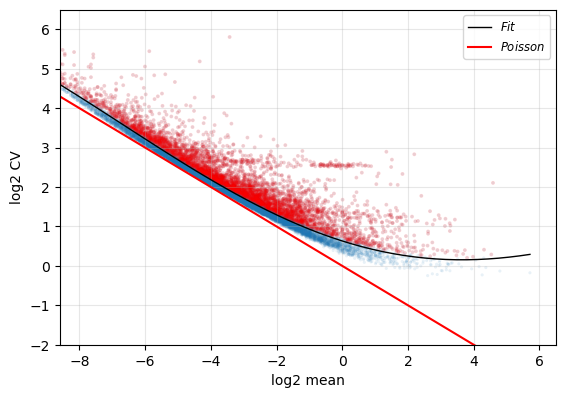

In [38]:
thrs = 4500

#Pre-filtering
df_f = df_proto.copy()
df_f = df_f.loc[np.sum(df_f>=1, 1)>=5,:] # is at least 1 in X cells
df_f = df_f.loc[np.sum(df_f>=2, 1)>=2,:] # is at least 2 in X cells
df_f = df_f.loc[np.sum(df_f>=3, 1)>=1,:] # is at least 2 in X cells

#Fitting
mu = df_f.mean(1).values
sigma = df_f.std(1, ddof=1).values
cv = sigma/mu
score, mu_linspace, cv_fit , params = fit_CV(mu,cv, 'SVR', svr_gamma=0.005)

#Plotting
def plot_cvmean():
    mp.figure()
    mp.scatter(np.log2(mu),np.log2(cv), marker='o', edgecolor ='none',alpha=0.1, s=5)
    mu_sorted = mu[np.argsort(score)[::-1]]
    cv_sorted = cv[np.argsort(score)[::-1]]
    mp.scatter(np.log2(mu_sorted[:thrs]),np.log2(cv_sorted[:thrs]), marker='o', edgecolor ='none',alpha=0.15, s=8, c='r')
    mp.plot(mu_linspace, cv_fit,'-k', linewidth=1, label='$Fit$')
    mp.plot(np.linspace(-9,7), -0.5*np.linspace(-9,7), '-r', label='$Poisson$')
    mp.ylabel('log2 CV')
    mp.xlabel('log2 mean')
    mp.grid(alpha=0.3)
    mp.xlim(-8.6,6.5)
    mp.ylim(-2,6.5)
    mp.legend(loc=1, fontsize='small')
    mp.gca().set_aspect(1.2)
    
plot_cvmean()

mp.savefig(r'HigFidCelProtoScoringMS/01.CVplot_devTop4500.pdf')
#Adjusting plot


In [39]:
#Confirm Selection
df_proto =  df_f.iloc[np.argsort(score)[::-1],:].iloc[:thrs,:]

## Train model

In [40]:
# Prepare dataset for training
df_proto_log = np.log2(df_proto + 1)
ct_oligo = cols_oligo_proto[df_proto.columns].loc['Prototype']
proto_group = proto.loc[ct_oligo].values
bool1 = proto_group != 'none'
classes_names, classes_index = np.unique(proto_group[bool1], return_inverse=True, return_counts=False)
train_index = classes_index
df_train_set = df_proto_log.loc[:,bool1].copy()

#Regularization path
normalizer = 0.9*df_train_set.values.max(1)[:,np.newaxis]

LR = LogisticRegressionCV(Cs=np.logspace(-4.25,1,30), refit=True, penalty='l2',
                          solver='newton-cg', fit_intercept=False, multi_class='multinomial',class_weight='balanced',
                          cv=StratifiedShuffleSplit(n_splits=35,test_size=0.15, random_state=123))

LR.fit((df_train_set.values/normalizer).T, train_index)


LogisticRegressionCV(Cs=array([5.62341325e-05, 8.53167852e-05, 1.29440137e-04, 1.96382800e-04,
       2.97946255e-04, 4.52035366e-04, 6.85814869e-04, 1.04049831e-03,
       1.57861368e-03, 2.39502662e-03, 3.63366451e-03, 5.51288979e-03,
       8.36399555e-03, 1.26896100e-02, 1.92523061e-02, 2.92090372e-02,
       4.43150990e-02, 6.72335754e-02, 1.02004819e-01, 1.54758735e-01,
       2.34795438e-01, 3.56224789e-01, 5.40453857e-01, 8.19960824e-01,
       1.24402064e+00, 1.88739182e+00, 2.86349581e+00, 4.34441230e+00,
       6.59121559e+00, 1.00000000e+01]),
                     class_weight='balanced',
                     cv=StratifiedShuffleSplit(n_splits=35, random_state=123, test_size=0.15,
            train_size=None),
                     fit_intercept=False, multi_class='multinomial',
                     solver='newton-cg')

In [41]:
print("Best C:", LR.C_)

Best C: [2.86349581 2.86349581 2.86349581 2.86349581 2.86349581 2.86349581
 2.86349581]


In [42]:
chos = 2.86

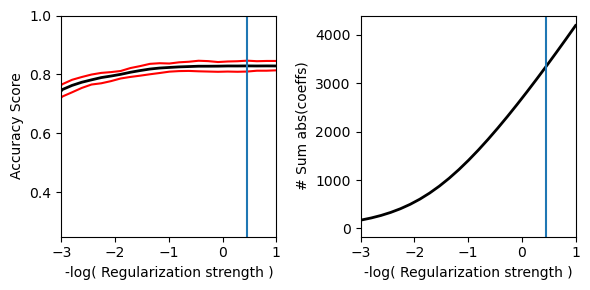

In [43]:
# Regularization path plot
mp.figure(figsize=(6,3))
mp.subplot(122)
CMA = np.array([abs(LR.coefs_paths_[i]) for i in range(len(set(classes_index)))])
val_ = np.array( [[sum( sum( CMA[:,i,j,:],0) ,0) for i in range(35)] for j in range(30) ] )
mp.plot( np.log10(LR.Cs_),\
     val_.mean(1), c='k' , lw=2 )
mp.xlabel('-log( Regularization strength )')
mp.ylabel('# Sum abs(coeffs)')
mp.xlim(-3,1)
mp.axvline( np.log10(chos) )

mp.subplot(121)
mp.plot(np.log10(LR.Cs_), np.mean([LR.scores_[i].mean(0) for i in range(len(set(classes_index)))],0), c='k', lw=2 )
mp.plot(np.log10(LR.Cs_), np.percentile( LR.scores_[1],97.5,0), c='r')
mp.plot(np.log10(LR.Cs_), np.percentile( LR.scores_[1],2.5,0), c='r')
mp.axvline( np.log10(chos) )
mp.ylabel('Accuracy Score')
mp.xlabel('-log( Regularization strength )')
mp.xlim(-3,1)
mp.ylim(0.25,1)

mp.tight_layout()
mp.savefig(r'HigFidCelProtoScoringMS/02.RegPath_dev_proto.pdf')

## Final model (Normalized by the max)

In [44]:
#%% Final model (Normalized by the max)
LR = LogisticRegression(C=chos, penalty='l2', solver='newton-cg', fit_intercept=False, 
                        multi_class='multinomial',class_weight='balanced',random_state=123)

normalizer = 0.9*df_train_set.values.max(1)[:,np.newaxis]
LR.fit((df_train_set.values / normalizer).T, train_index)

LogisticRegression(C=2.86, class_weight='balanced', fit_intercept=False,
                   multi_class='multinomial', random_state=123,
                   solver='newton-cg')

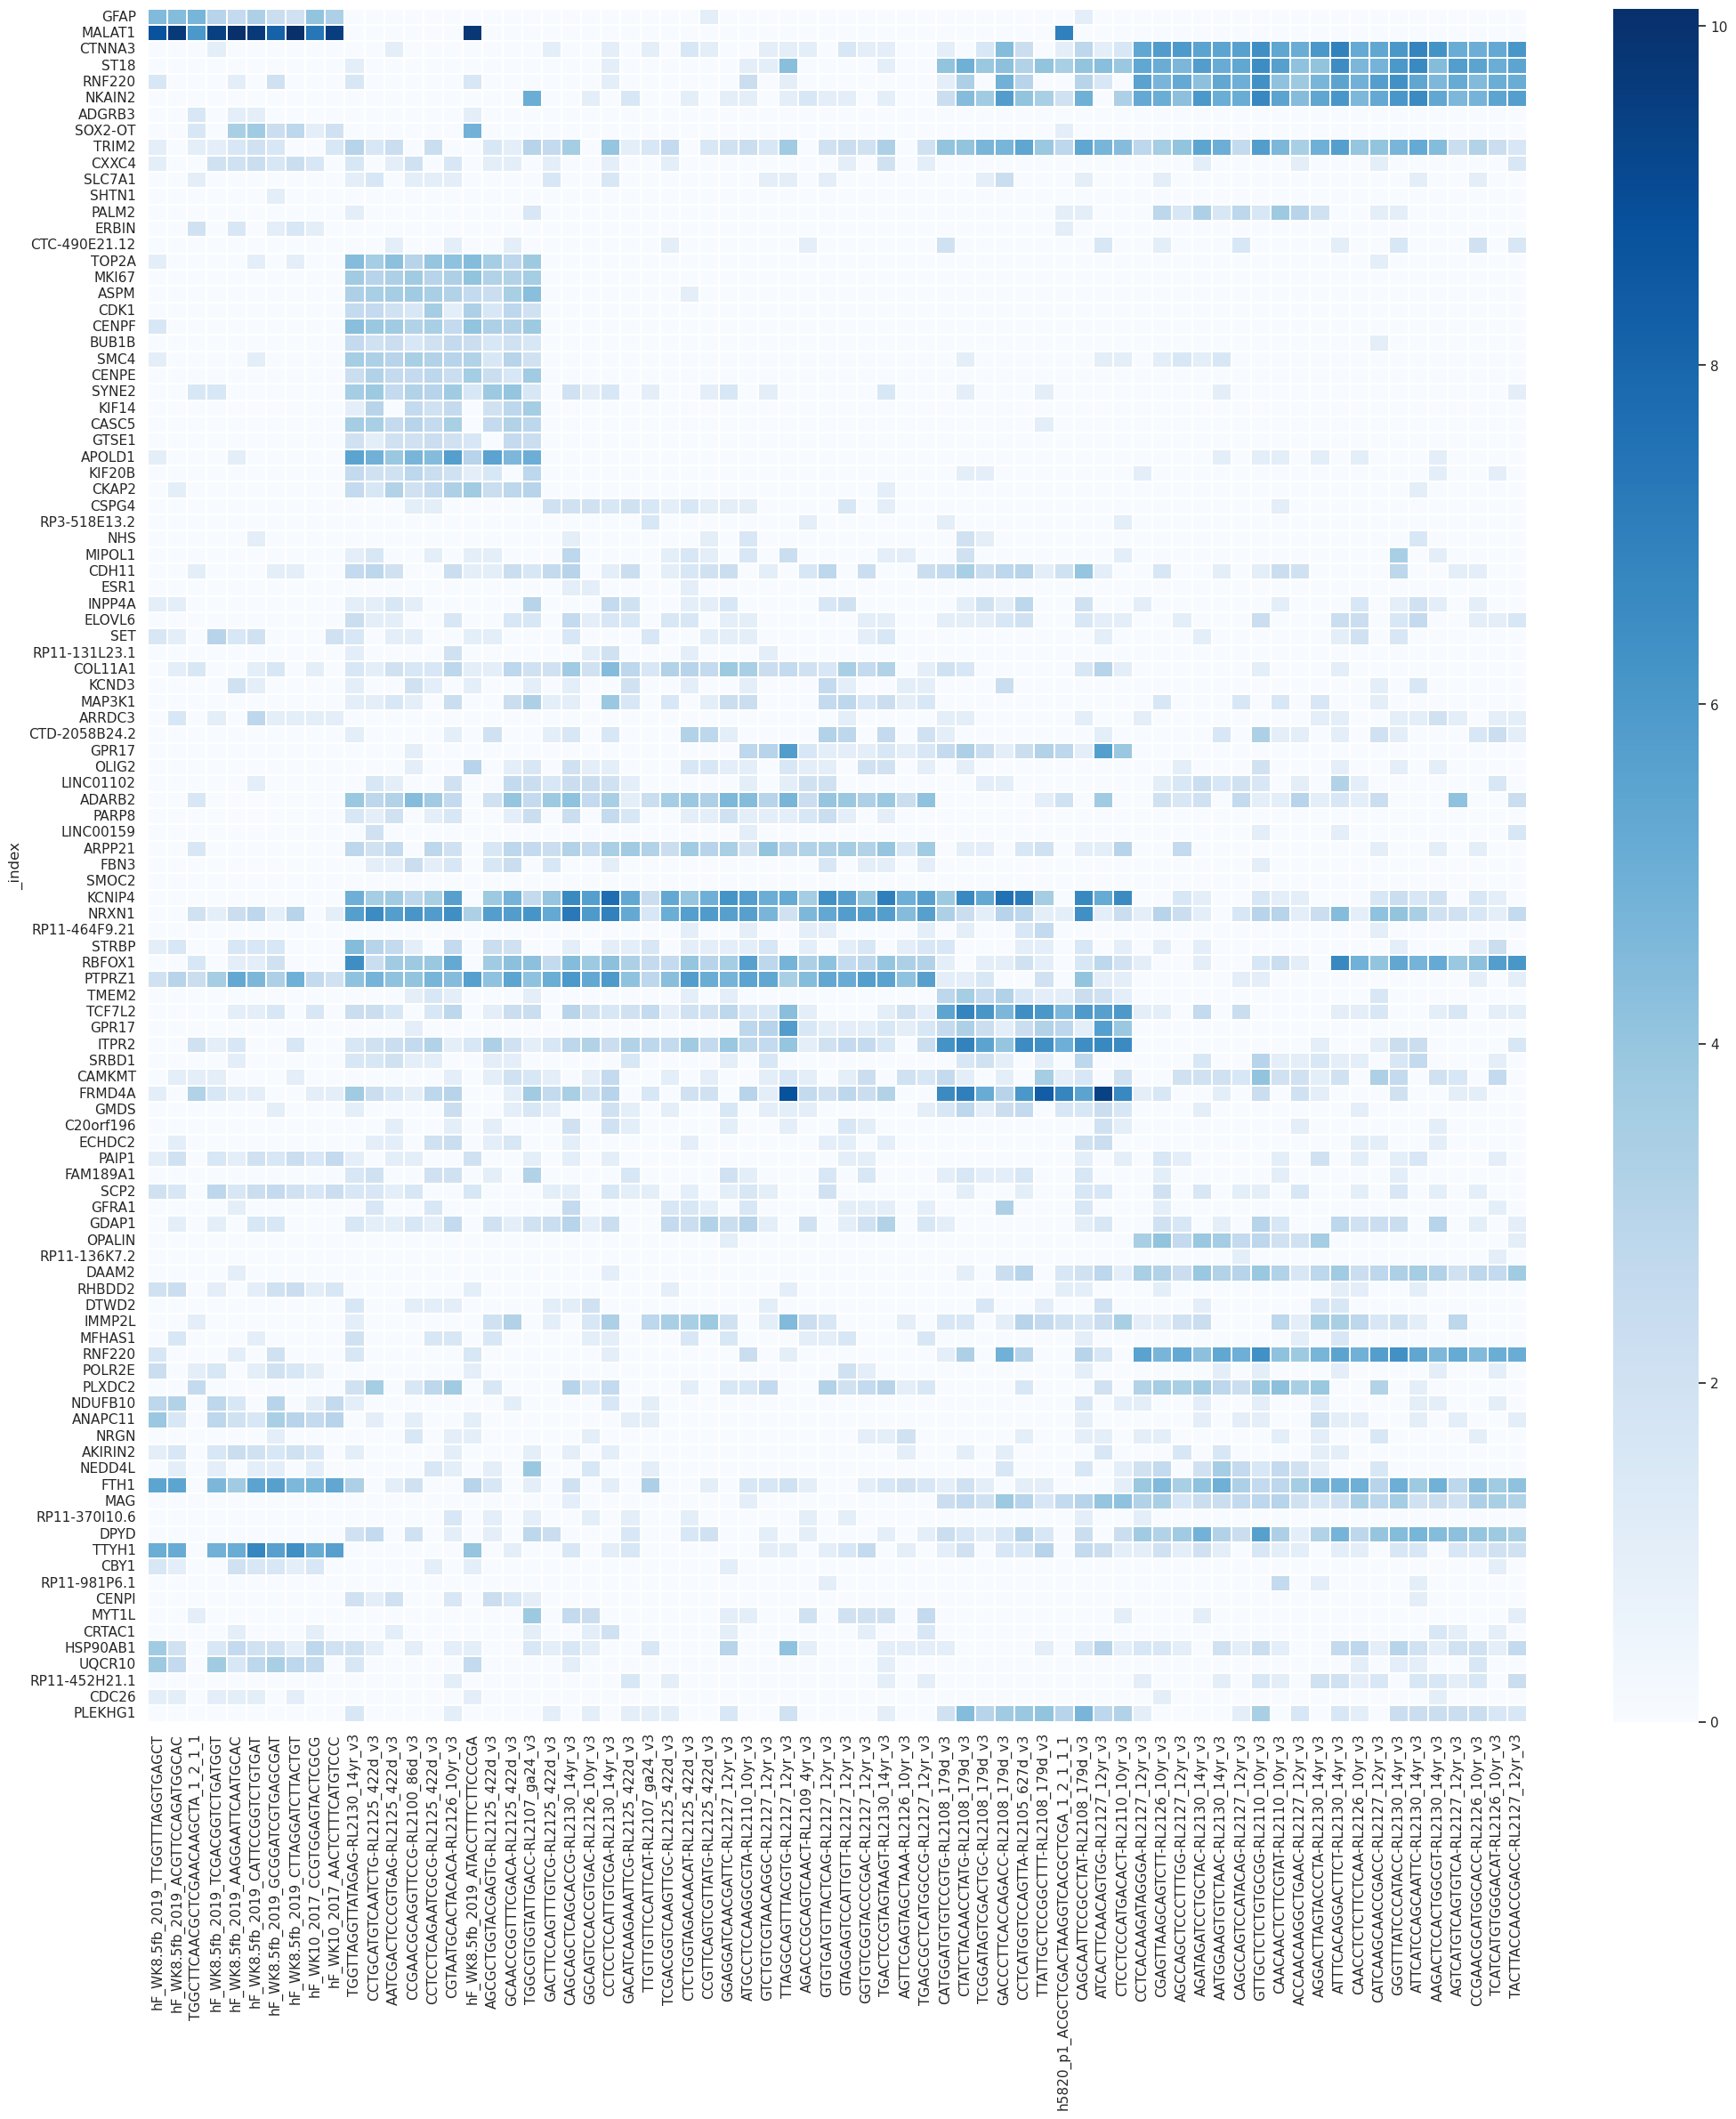

In [45]:
#%% Viualize the top positive weights for each prototype as a heatmap
sel_class = 'proto_PreOPC'
nonzero_coef_bool = LR.coef_[np.where( classes_names == sel_class )[0][0], :] > 0
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
names_nonzero_coef= df_proto_log.index[nonzero_coef_bool]
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]
names_sorted_coef_proto1 = names_sorted_coef

sel_class = 'proto_DividingOPC'
nonzero_coef_bool = LR.coef_[np.where( classes_names == sel_class )[0][0], :] > 0
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
names_nonzero_coef= df_proto_log.index[nonzero_coef_bool]
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]
names_sorted_coef_proto2 = names_sorted_coef

sel_class = 'proto_LateOPC'
nonzero_coef_bool = LR.coef_[np.where( classes_names == sel_class )[0][0], :] > 0
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
names_nonzero_coef= df_proto_log.index[nonzero_coef_bool]
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]
names_sorted_coef_proto3 = names_sorted_coef

sel_class = 'proto_COP'
nonzero_coef_bool = LR.coef_[np.where( classes_names == sel_class )[0][0], :] > 0
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
names_nonzero_coef= df_proto_log.index[nonzero_coef_bool]
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]
names_sorted_coef_proto4 = names_sorted_coef

sel_class = 'proto_NFOL'
nonzero_coef_bool = LR.coef_[np.where( classes_names == sel_class )[0][0], :] > 0
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
names_nonzero_coef= df_proto_log.index[nonzero_coef_bool]
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]
names_sorted_coef_proto5 = names_sorted_coef

sel_class = 'proto_MFOL'
nonzero_coef_bool = LR.coef_[np.where( classes_names == sel_class )[0][0], :] > 0
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
names_nonzero_coef= df_proto_log.index[nonzero_coef_bool]
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]
names_sorted_coef_proto6 = names_sorted_coef

sel_class = 'proto_MOL'
nonzero_coef_bool = LR.coef_[np.where( classes_names == sel_class )[0][0], :] > 0
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
names_nonzero_coef= df_proto_log.index[nonzero_coef_bool]
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]
names_sorted_coef_proto7 = names_sorted_coef


# Predict cell scores and pick top cells
res = LR.predict_proba((df_train_set.values / normalizer).T)
hist_order = ['proto_PreOPC', 'proto_DividingOPC', 'proto_LateOPC', 'proto_COP', 'proto_NFOL', 'proto_MFOL', 'proto_MOL']
hist_ixes = [list(classes_names).index(i) for i in hist_order]
resdf = pd.DataFrame(res)
resdf.columns = classes_names
resdf.index = df_train_set.columns

# Make a heatmap
top10cells_proto1 = resdf.sort_values('proto_PreOPC', ascending=False)[:10].index
top10cells_proto2 = resdf.sort_values('proto_DividingOPC', ascending=False)[:10].index
top10cells_proto3 = resdf.sort_values('proto_LateOPC', ascending=False)[:10].index
top10cells_proto4 = resdf.sort_values('proto_COP', ascending=False)[:10].index
top10cells_proto5 = resdf.sort_values('proto_NFOL', ascending=False)[:10].index
top10cells_proto6 = resdf.sort_values('proto_MFOL', ascending=False)[:10].index
top10cells_proto7 = resdf.sort_values('proto_MOL', ascending=False)[:10].index

top15genes_proto1 = names_sorted_coef_proto1[:15]
top15genes_proto2 = names_sorted_coef_proto2[:15]
top15genes_proto3 = names_sorted_coef_proto3[:15]
top15genes_proto4 = names_sorted_coef_proto4[:15]
top15genes_proto5 = names_sorted_coef_proto5[:15]
top15genes_proto6 = names_sorted_coef_proto6[:15]
top15genes_proto7 = names_sorted_coef_proto7[:15]


topcellsheatmap = df_train_set.loc[top15genes_proto1.tolist() + top15genes_proto2.tolist() + top15genes_proto3.tolist() + top15genes_proto4.tolist() + top15genes_proto5.tolist() + top15genes_proto6.tolist() + top15genes_proto7.tolist(),
                                   top10cells_proto1.tolist() + top10cells_proto2.tolist() + top10cells_proto3.tolist() + top10cells_proto4.tolist() + top10cells_proto5.tolist() + top10cells_proto6.tolist() + top10cells_proto7.tolist()]

mp.rcParams['savefig.dpi'] = 100
mp.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.heatmap(topcellsheatmap, cmap = 'Blues', linewidths = 0.2, annot=False)
mp.savefig(r'HigFidCelProtoScoringMS/TopWeightHeatmap_infant_hip.pdf')

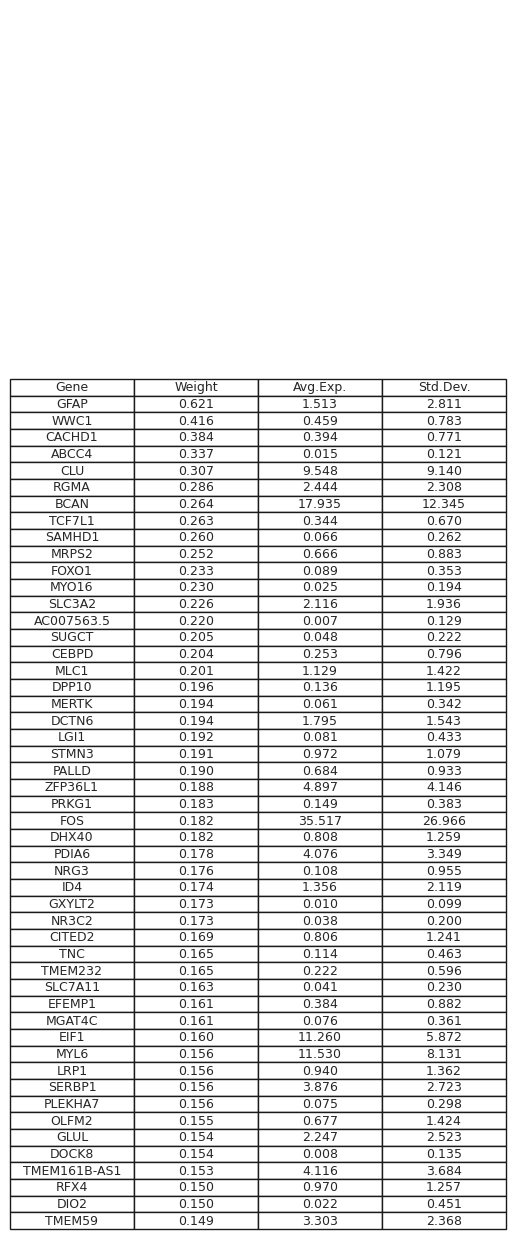

In [32]:
#%% Viualize the top 50 positive weights defining pre-OPC proto
sel_class = 'proto_PreOPC'
nonzero_coef_bool = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
names_nonzero_coef= df_proto_log.index
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]

avg_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].mean(1)
std_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].std(1)

# Plot in a matplotlib table
mp.rcParams['savefig.dpi'] = 300
colLabels=("Gene", "Weight", 'Avg.Exp.', 'Std.Dev.')
rows_list = zip(list(names_sorted_coef)[:50],\
                list(map(lambda x: '%.3f' % x, values_sorted_coef[:50])),\
                list(map(lambda x: '%.3f' % x, avg_expr[:50])),\
                list(map(lambda x: '%.3f' % x, std_expr[:50])))
rows_list = list(rows_list)
nrows, ncols = len(rows_list)+1, len(colLabels)
hcell, wcell = 0.02, 0.7
hpad, wpad = 0, 0
fig = mp.figure()
ax = fig.add_subplot(111)
ax.axis('off')
the_table = ax.table(cellText=rows_list, colLabels=colLabels, cellLoc='center')
mp.savefig(r'HigFidCelProtoScoringMS/Top50_pre-OPC_proto.pdf')

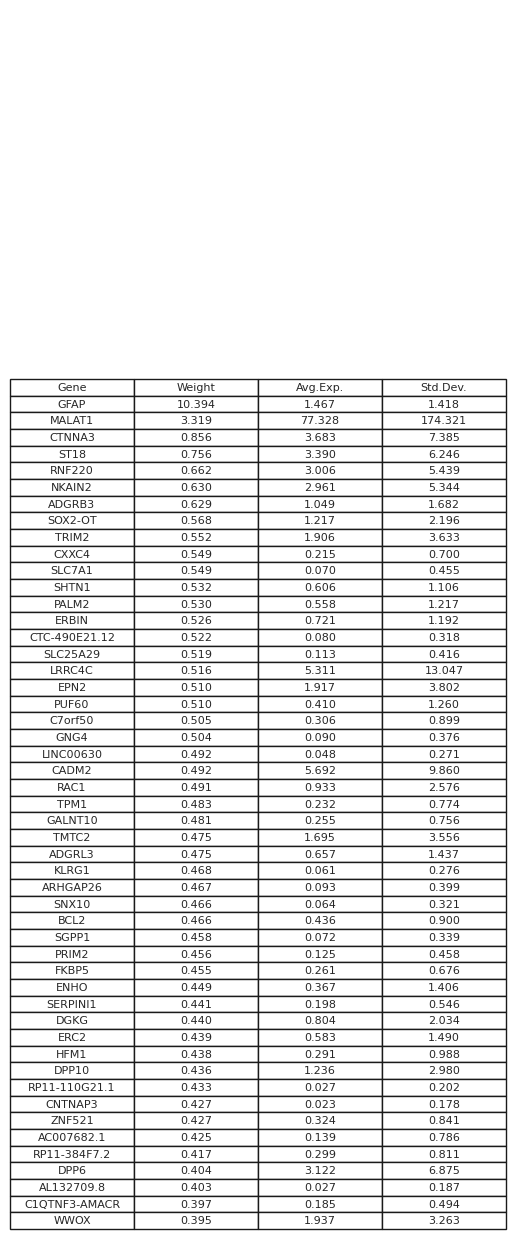

In [46]:
#%% Viualize the top 50 positive weights defining pre-OPC proto
sel_class = 'proto_PreOPC'
nonzero_coef_bool = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
names_nonzero_coef= df_proto_log.index
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]

avg_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].mean(1)
std_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].std(1)

# Plot in a matplotlib table
mp.rcParams['savefig.dpi'] = 300
colLabels=("Gene", "Weight", 'Avg.Exp.', 'Std.Dev.')
rows_list = zip(list(names_sorted_coef)[:50],\
                list(map(lambda x: '%.3f' % x, values_sorted_coef[:50])),\
                list(map(lambda x: '%.3f' % x, avg_expr[:50])),\
                list(map(lambda x: '%.3f' % x, std_expr[:50])))
rows_list = list(rows_list)
nrows, ncols = len(rows_list)+1, len(colLabels)
hcell, wcell = 0.02, 0.7
hpad, wpad = 0, 0
fig = mp.figure()
ax = fig.add_subplot(111)
ax.axis('off')
the_table = ax.table(cellText=rows_list, colLabels=colLabels, cellLoc='center')
mp.savefig(r'HigFidCelProtoScoringMS/Top50_pre-OPC_proto.pdf')

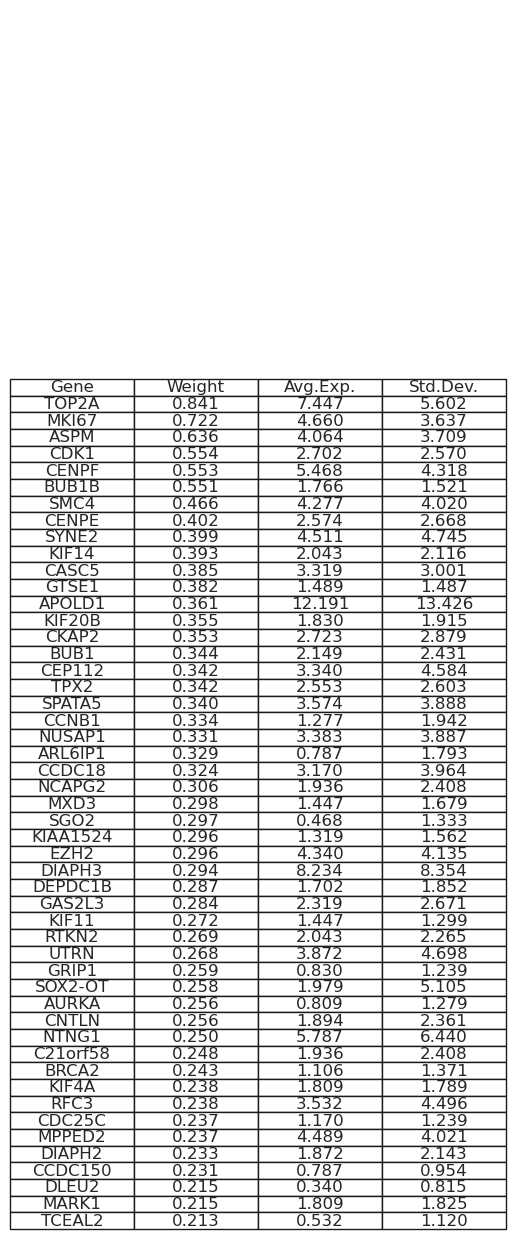

In [47]:
#%% Viualize the top 50 positive weights defining dividing OPC proto
sel_class = 'proto_DividingOPC'
nonzero_coef_bool = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
names_nonzero_coef= df_proto_log.index
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]

avg_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].mean(1)
std_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].std(1)

# Plot in a matplotlib table
mp.rcParams['savefig.dpi'] = 300
colLabels=("Gene", "Weight", 'Avg.Exp.', 'Std.Dev.')
rows_list = zip(list(names_sorted_coef)[:50],\
                list(map(lambda x: '%.3f' % x, values_sorted_coef[:50])),\
                list(map(lambda x: '%.3f' % x, avg_expr[:50])),\
                list(map(lambda x: '%.3f' % x, std_expr[:50])))
rows_list = list(rows_list)
nrows, ncols = len(rows_list)+1, len(colLabels)
hcell, wcell = 0.02, 0.7
hpad, wpad = 0, 0
fig = mp.figure()
ax = fig.add_subplot(111)
ax.axis('off')
the_table = ax.table(cellText=rows_list, colLabels=colLabels, cellLoc='center')
mp.savefig(r'HigFidCelProtoScoringMS/Top50_DividingOPC_proto.pdf')

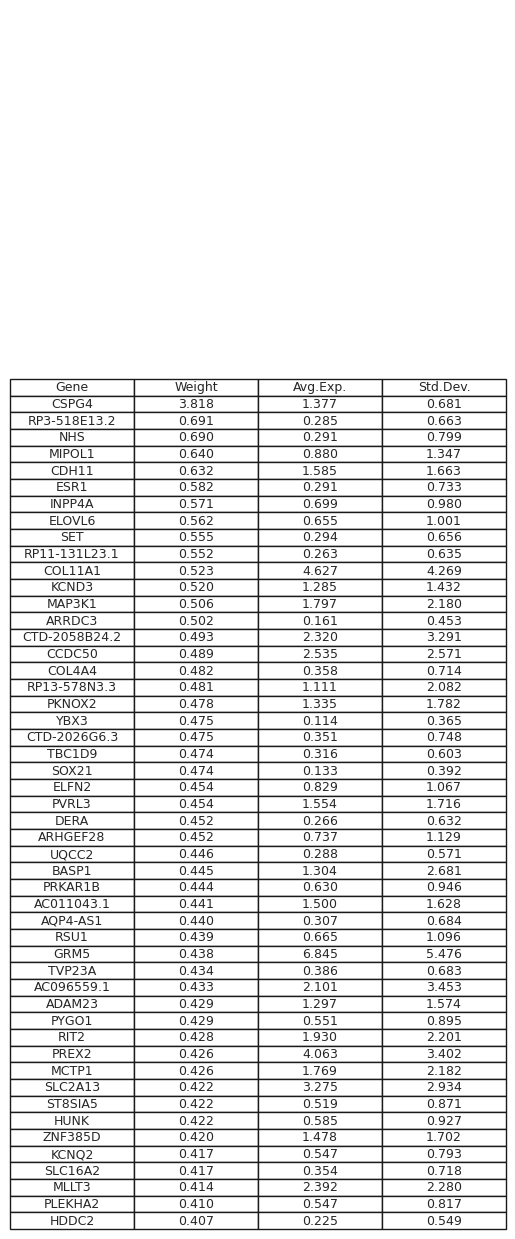

In [48]:
#%% Viualize the top 50 positive weights defining late OPC proto
sel_class = 'proto_LateOPC'
nonzero_coef_bool = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
names_nonzero_coef= df_proto_log.index
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]

avg_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].mean(1)
std_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].std(1)

# Plot in a matplotlib table
mp.rcParams['savefig.dpi'] = 300
colLabels=("Gene", "Weight", 'Avg.Exp.', 'Std.Dev.')
rows_list = zip(list(names_sorted_coef)[:50],\
                list(map(lambda x: '%.3f' % x, values_sorted_coef[:50])),\
                list(map(lambda x: '%.3f' % x, avg_expr[:50])),\
                list(map(lambda x: '%.3f' % x, std_expr[:50])))
rows_list = list(rows_list)
nrows, ncols = len(rows_list)+1, len(colLabels)
hcell, wcell = 0.02, 0.7
hpad, wpad = 0, 0
fig = mp.figure()
ax = fig.add_subplot(111)
ax.axis('off')
the_table = ax.table(cellText=rows_list, colLabels=colLabels, cellLoc='center')
mp.savefig(r'HigFidCelProtoScoringMS/Top50_LateOPC_proto.pdf')

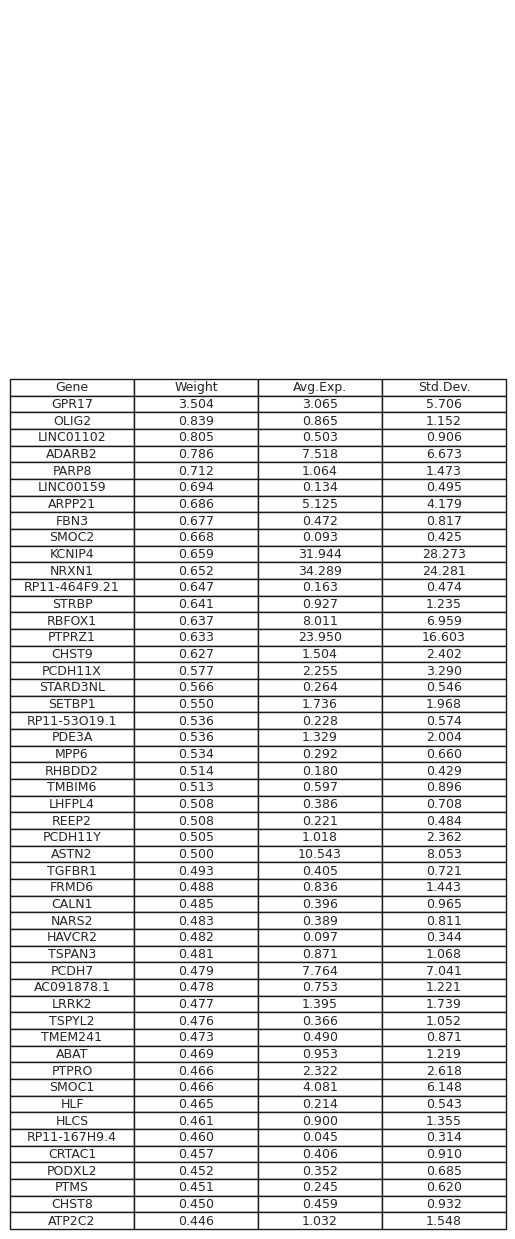

In [49]:
#%% Viualize the top 50 positive weights defining COP proto
sel_class = 'proto_COP'
nonzero_coef_bool = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
names_nonzero_coef= df_proto_log.index
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]

avg_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].mean(1)
std_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].std(1)

# Plot in a matplotlib table
mp.rcParams['savefig.dpi'] = 300
colLabels=("Gene", "Weight", 'Avg.Exp.', 'Std.Dev.')
rows_list = zip(list(names_sorted_coef)[:50],\
                list(map(lambda x: '%.3f' % x, values_sorted_coef[:50])),\
                list(map(lambda x: '%.3f' % x, avg_expr[:50])),\
                list(map(lambda x: '%.3f' % x, std_expr[:50])))
rows_list = list(rows_list)
nrows, ncols = len(rows_list)+1, len(colLabels)
hcell, wcell = 0.02, 0.7
hpad, wpad = 0, 0
fig = mp.figure()
ax = fig.add_subplot(111)
ax.axis('off')
the_table = ax.table(cellText=rows_list, colLabels=colLabels, cellLoc='center')
mp.savefig(r'HigFidCelProtoScoringMS/Top50_COP_proto.pdf')

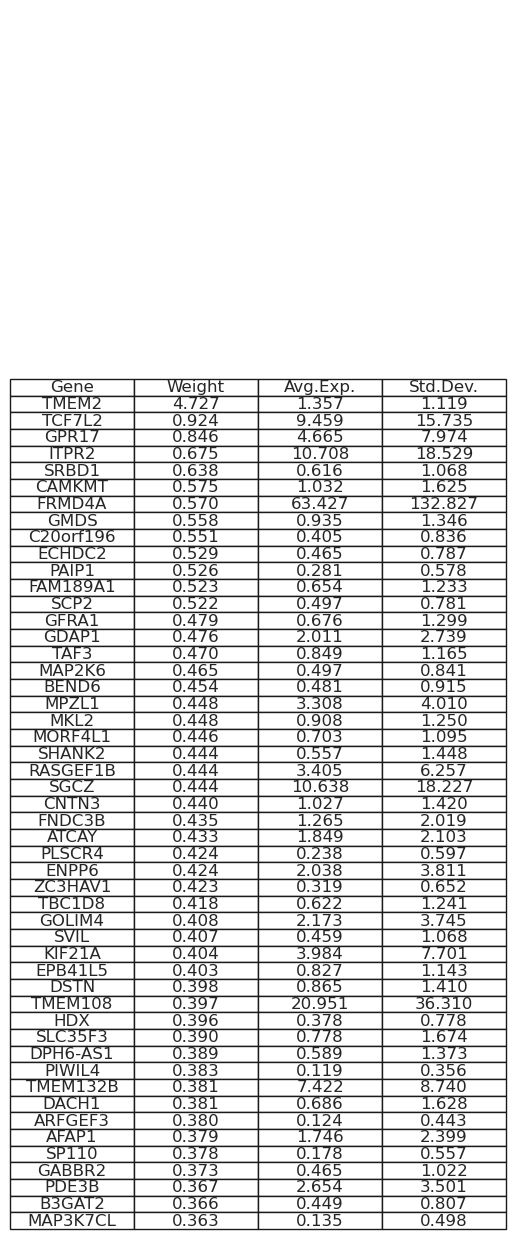

In [50]:
#%% Viualize the top 50 positive weights defining NFOL proto
sel_class = 'proto_NFOL'
nonzero_coef_bool = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
names_nonzero_coef= df_proto_log.index
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]

avg_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].mean(1)
std_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].std(1)

# Plot in a matplotlib table
mp.rcParams['savefig.dpi'] = 300
colLabels=("Gene", "Weight", 'Avg.Exp.', 'Std.Dev.')
rows_list = zip(list(names_sorted_coef)[:50],\
                list(map(lambda x: '%.3f' % x, values_sorted_coef[:50])),\
                list(map(lambda x: '%.3f' % x, avg_expr[:50])),\
                list(map(lambda x: '%.3f' % x, std_expr[:50])))
rows_list = list(rows_list)
nrows, ncols = len(rows_list)+1, len(colLabels)
hcell, wcell = 0.02, 0.7
hpad, wpad = 0, 0
fig = mp.figure()
ax = fig.add_subplot(111)
ax.axis('off')
the_table = ax.table(cellText=rows_list, colLabels=colLabels, cellLoc='center')
mp.savefig(r'HigFidCelProtoScoringMS/Top50_NFOL_proto.pdf')

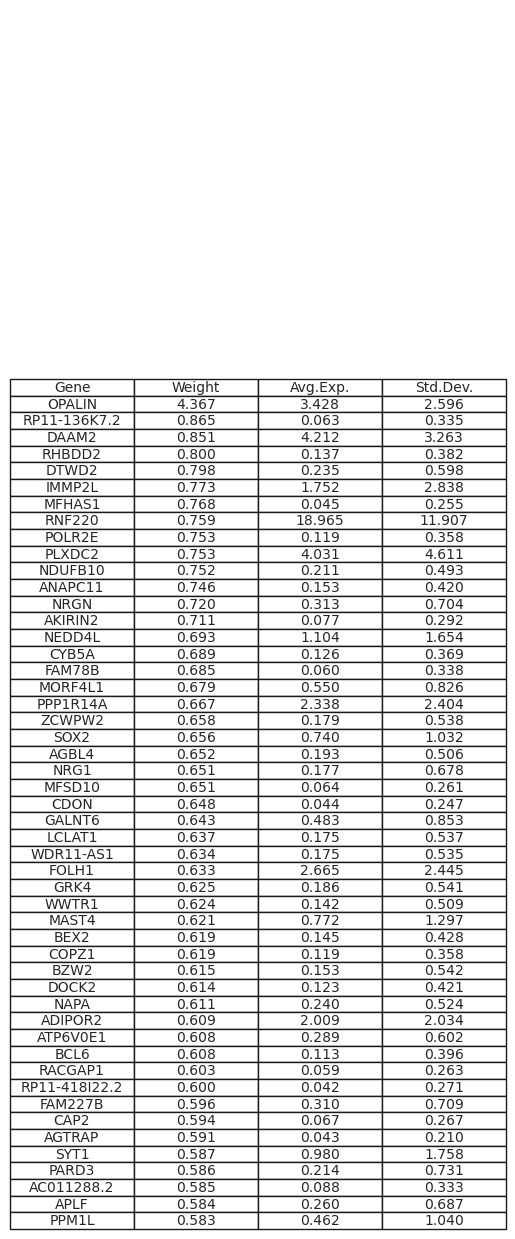

In [51]:
#%% Viualize the top 50 positive weights defining MFOL proto
sel_class = 'proto_MFOL'
nonzero_coef_bool = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
names_nonzero_coef= df_proto_log.index
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]

avg_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].mean(1)
std_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].std(1)

# Plot in a matplotlib table
mp.rcParams['savefig.dpi'] = 300
colLabels=("Gene", "Weight", 'Avg.Exp.', 'Std.Dev.')
rows_list = zip(list(names_sorted_coef)[:50],\
                list(map(lambda x: '%.3f' % x, values_sorted_coef[:50])),\
                list(map(lambda x: '%.3f' % x, avg_expr[:50])),\
                list(map(lambda x: '%.3f' % x, std_expr[:50])))
rows_list = list(rows_list)
nrows, ncols = len(rows_list)+1, len(colLabels)
hcell, wcell = 0.02, 0.7
hpad, wpad = 0, 0
fig = mp.figure()
ax = fig.add_subplot(111)
ax.axis('off')
the_table = ax.table(cellText=rows_list, colLabels=colLabels, cellLoc='center')
mp.savefig(r'HigFidCelProtoScoringMS/Top50_MFOL_proto.pdf')

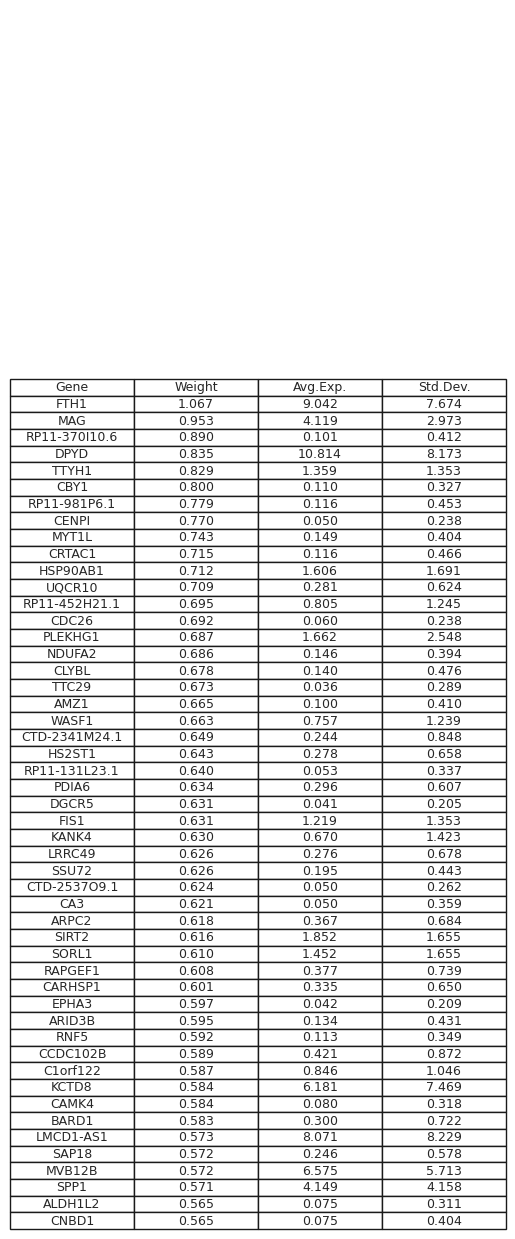

In [52]:
#%% Viualize the top 50 positive weights defining MOL proto
sel_class = 'proto_MOL'
nonzero_coef_bool = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
names_nonzero_coef= df_proto_log.index
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]

avg_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].mean(1)
std_expr = df_proto.loc[names_sorted_coef, proto_group == sel_class].std(1)

# Plot in a matplotlib table
mp.rcParams['savefig.dpi'] = 300
colLabels=("Gene", "Weight", 'Avg.Exp.', 'Std.Dev.')
rows_list = zip(list(names_sorted_coef)[:50],\
                list(map(lambda x: '%.3f' % x, values_sorted_coef[:50])),\
                list(map(lambda x: '%.3f' % x, avg_expr[:50])),\
                list(map(lambda x: '%.3f' % x, std_expr[:50])))
rows_list = list(rows_list)
nrows, ncols = len(rows_list)+1, len(colLabels)
hcell, wcell = 0.02, 0.7
hpad, wpad = 0, 0
fig = mp.figure()
ax = fig.add_subplot(111)
ax.axis('off')
the_table = ax.table(cellText=rows_list, colLabels=colLabels, cellLoc='center')
mp.savefig(r'HigFidCelProtoScoringMS/Top50_MOL_proto.pdf')

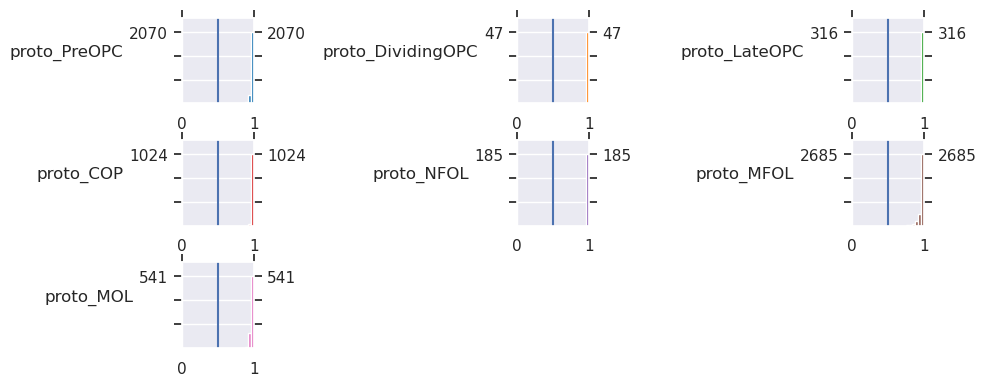

In [53]:
mp.figure(figsize=(10,4))
pobs_list = []
for z,i in enumerate(hist_ixes):
    mp.subplot(int(len(set(classes_index))/2), 3, z+1)
    prob = LR.predict_proba((df_train_set.values[:,classes_index==i]/ normalizer).T)[:,i]
    amounts,_,_ = mp.hist(prob, color=np.array(proto_color[classes_names[i]])/255.,bins=np.linspace(0,1,25) )
    pobs_list.append([ classes_names[i], np.mean(prob)])
    
    if z == len(hist_ixes)-1:
        mp.tick_params('both',which='both', right='on',left='off',top='off',
                       labelleft='off',labelbottom='on',labelright='on')
    mp.axvline(0.5)
    mp.xlim(0.,1)
    mp.ylabel(classes_names[i],rotation='horizontal',horizontalalignment = 'right')
    mp.yticks(np.linspace(0,max(amounts), 4 )[1:],['','','%d' % ( max(amounts) )])
    mp.ylim(0,1.2*max(amounts))
    mp.tick_params('both',which='both', right='on',left='off',top='off',
                   labelleft='off',labelbottom='off',labelright='on')
mp.tight_layout(pad=1,h_pad=0,w_pad=1)
mp.savefig(r'HigFidCelProtoScoringMS/Histograms_classifier_scores_dev.pdf')

## Wheel/Polygonal plot

In [54]:
def polygonalPlot(data, scaling=True,start_angle=90, rotate_labels=True, labels=('one','two','three'),\
                sides=3, label_offset=0.10, edge_args={'color':'black','linewidth':2},\
                fig_args = {'figsize':(8,8),'facecolor':'white','edgecolor':'white'},):
    '''
    This will create a basic polygonal plot

    # Scale data for plot (i.e. a + b + c = 1)
    scaling=True,
    # Direction of first vertex.
    start_angle=90,
    # Orient labels perpendicular to vertices.
    rotate_labels=True,
    # Labels for vertices.
    labels=('one','two','three')
    # Offset for label from vertex (percent of distance from origin).
    label_offset=0.10,
    # Any matplotlib keyword args for plots.
    edge_args={'color':'black','linewidth':2},
    # Any matplotlib keyword args for figures.
    fig_args = {'figsize':(8,8),'facecolor':'white','edgecolor':'white'},
    '''
    basis = np.array([[math.cos(2*i*math.pi/sides + start_angle*math.pi/180),
                    math.sin(2*i*math.pi/sides + start_angle*math.pi/180)] for i in range(sides)])

    # If data is Nxsides, newdata is Nx2.
    if scaling:
        # Scales data
        newdata = np.dot((data.T / data.sum(-1)).T,basis)
    else:
        # Assumes data already sums to 1.
        newdata = np.dot(data,basis)

    fig = mp.figure(**fig_args)
    ax = fig.add_subplot(111)

    for i,l in enumerate(labels):
        if i >= sides:
            break
        x = basis[i,0]
        y = basis[i,1]
        if rotate_labels:
            angle = 180*math.atan(y/x)/math.pi + 90
            if angle > 90 and angle <= 270:
                angle = mod(angle + 180,360)
        else:
            angle = 0
        ax.text(
                x*(1 + label_offset),
                y*(1 + label_offset),
                l,
                horizontalalignment='center',
                verticalalignment='center',
                rotation=angle
            )

    # Clear normal matplotlib axes graphics
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_frame_on(False)

    # Plot borders
    ax.plot([basis[_,0] for _ in list(range(sides)) + [0,]],
            [basis[_,1] for _ in list(range(sides)) + [0,]],
            **edge_args)

    return newdata,ax

In [55]:
### Plot wheel plot
wanted_order = ['proto_PreOPC', 'proto_DividingOPC', 'proto_LateOPC', 'proto_COP', 
                'proto_NFOL', 'proto_MFOL', 'proto_MOL',]
reorder_ix = [list(classes_names).index(i) for i in wanted_order]
bool00 = np.in1d( classes_names[classes_index],  wanted_order )

In [56]:
color_dict = pd.Series({'pre-OPC':(31, 119, 180), 
                        'dividing-OPC':(255, 127, 14),
                        'late-OPC':(44, 160, 44), 
                        'COP':(214, 39, 40), 
                        'NFOL':(148, 103, 189),
                        'MFOL':(140, 86, 75),
                        'MOL':(227, 119, 194)})
color_dict = color_dict.map(lambda x: list(map(lambda y: y/255., x))) ## list: Convert the map to a list

In [57]:
from operator import mod

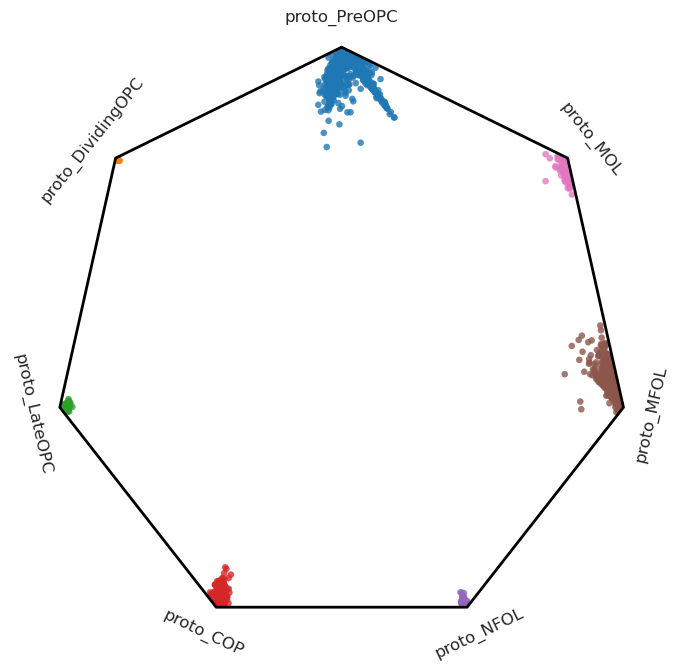

In [58]:
mp.rcParams['savefig.dpi'] = 90
newcolors = np.array(list(color_dict[cols_oligo_proto.loc[:,df_train_set.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba((df_train_set.values/ df_train_set.values.max(1)[:,np.newaxis]).T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[bool00,0]*0.99, newdata[bool00,1]*0.99, alpha=0.8,\
           c=newcolors[bool00,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_train_oligo.pdf')

## Test  developmental dataset

### Scoring fetal stege oligo

In [59]:
df_oligo_Fetal = df_proto.loc[:,cols_oligo_all.loc['AgeGroup_5']=='Fetal']
df_in = df_oligo_Fetal.loc[df_proto.index].copy()
max_values = df_in.values.max(1)
# Avoid division by zero
max_values[max_values == 0] = 1  # Set to a non-zero value
result = df_in.values / max_values[:, np.newaxis]

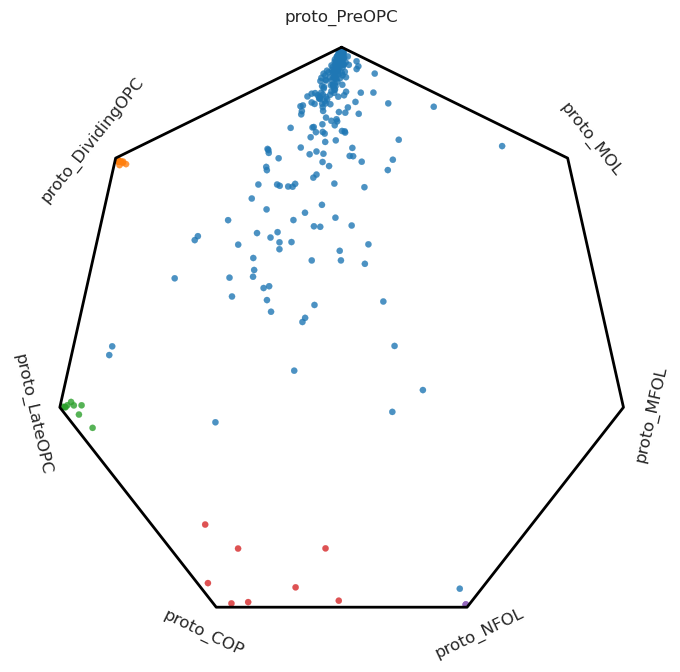

In [60]:
mp.rcParams['savefig.dpi'] = 90
newcolors = np.array(list(color_dict[cols_oligo_proto.loc[:,df_in.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba(result.T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[:,0]*0.99, newdata[:,1]*0.99, alpha=0.8,\
           c=newcolors[:,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_Fetal_oligo.pdf')

### Scoring infant stege oligo

In [61]:
df_oligo_Infancy = df_proto.loc[:,cols_oligo_all.loc['AgeGroup_5']=='Infancy']
df_in = df_oligo_Infancy.loc[df_proto.index].copy()
max_values = df_in.values.max(1)
# Avoid division by zero
max_values[max_values == 0] = 1  # Set to a non-zero value
result = df_in.values / max_values[:, np.newaxis]

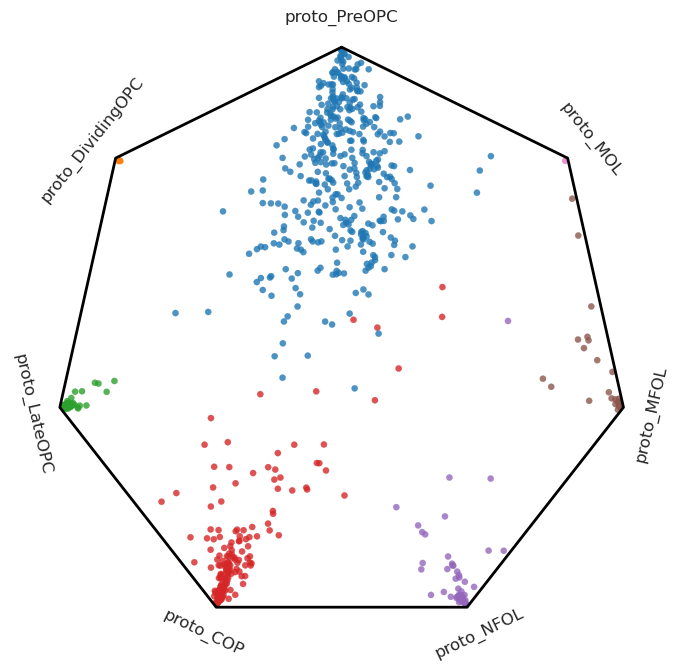

In [62]:
mp.rcParams['savefig.dpi'] = 90
newcolors = np.array(list(color_dict[cols_oligo_proto.loc[:,df_in.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba(result.T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[:,0]*0.99, newdata[:,1]*0.99, alpha=0.8,\
           c=newcolors[:,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_Infancy_oligo.pdf')

### Scoring Childhood stege oligo

In [63]:
df_oligo_Childhood = df_proto.loc[:,cols_oligo_all.loc['AgeGroup_5']=='Childhood']
df_in = df_oligo_Childhood.loc[df_proto.index].copy()
max_values = df_in.values.max(1)
# Avoid division by zero
max_values[max_values == 0] = 1  # Set to a non-zero value
result = df_in.values / max_values[:, np.newaxis]

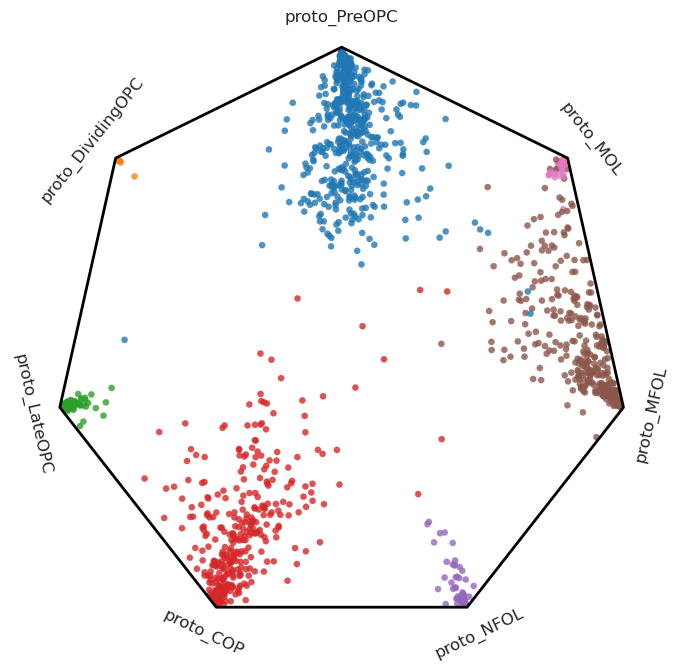

In [64]:
mp.rcParams['savefig.dpi'] = 90
newcolors = np.array(list(color_dict[cols_oligo_proto.loc[:,df_in.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba(result.T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[:,0]*0.99, newdata[:,1]*0.99, alpha=0.8,\
           c=newcolors[:,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_Childhood_oligo.pdf')

### Scoring Adolescence stege oligo

In [65]:
df_oligo_Adolescence = df_proto.loc[:,cols_oligo_all.loc['AgeGroup_5']=='Adolescence']
df_in = df_oligo_Adolescence.loc[df_proto.index].copy()
max_values = df_in.values.max(1)
# Avoid division by zero
max_values[max_values == 0] = 1  # Set to a non-zero value
result = df_in.values / max_values[:, np.newaxis]

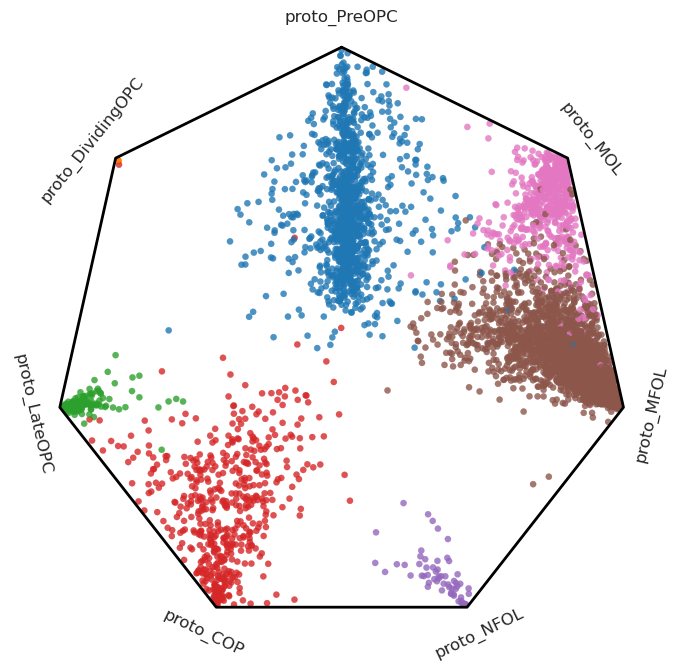

In [66]:
mp.rcParams['savefig.dpi'] = 90
newcolors = np.array(list(color_dict[cols_oligo_proto.loc[:,df_in.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba(result.T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[:,0]*0.99, newdata[:,1]*0.99, alpha=0.8,\
           c=newcolors[:,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_Adolescence_oligo.pdf')

### Scoring Adult stege oligo

In [68]:
df_oligo_Adult = df_dev.loc[:,cols_oligo_all.loc['AgeGroup_5']=='Adult']
df_in = df_oligo_Adult.loc[df_proto.index].copy()
max_values = df_in.values.max(1)
# Avoid division by zero
max_values[max_values == 0] = 1  # Set to a non-zero value
result = df_in.values / max_values[:, np.newaxis]

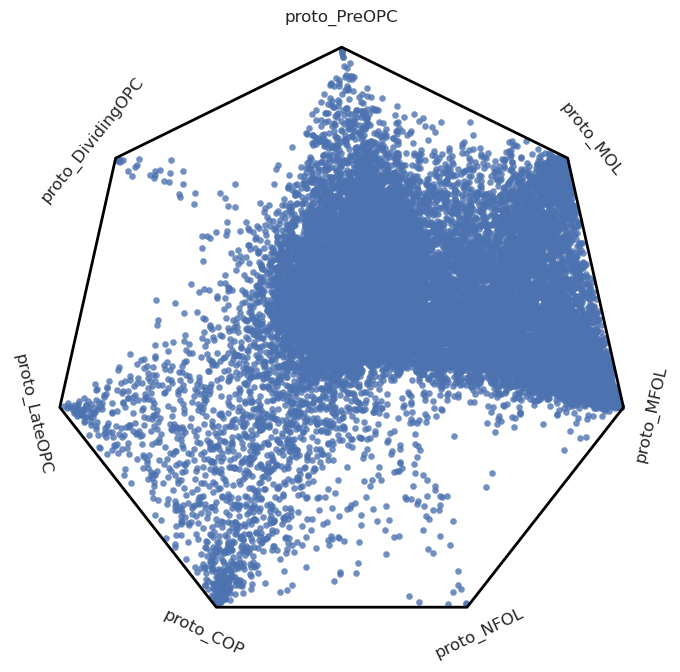

In [70]:
mp.rcParams['savefig.dpi'] = 90
#newcolors = np.array(list(color_dict[cols_oligo_proto.loc[:,df_in.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba(result.T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[:,0]*0.99, newdata[:,1]*0.99, alpha=0.8,\
#           c=newcolors[:,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_Adult_oligo.pdf')

### Scoring Aging stege oligo

In [71]:
df_oligo_Aging = df_dev.loc[:,cols_oligo_all.loc['AgeGroup_5']=='Aging']
df_in = df_oligo_Aging.loc[df_proto.index].copy()
max_values = df_in.values.max(1)
# Avoid division by zero
max_values[max_values == 0] = 1  # Set to a non-zero value
result = df_in.values / max_values[:, np.newaxis]

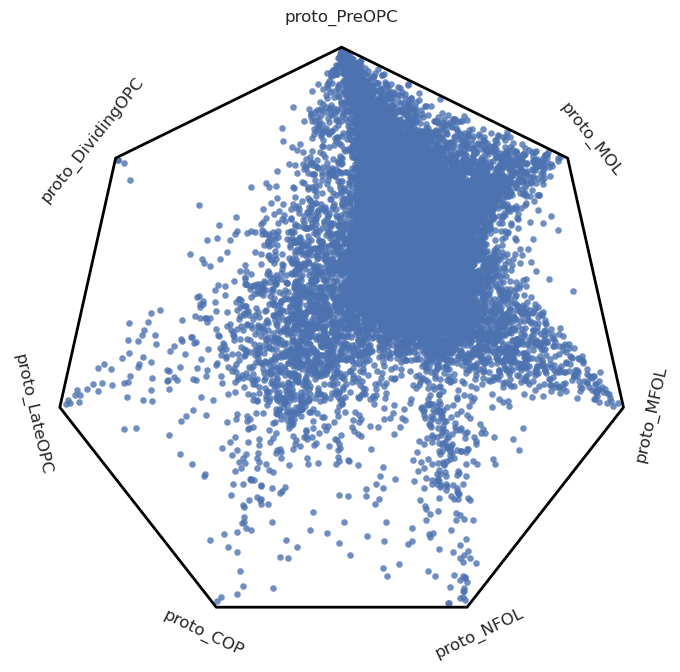

In [72]:
mp.rcParams['savefig.dpi'] = 90
#newcolors = np.array(list(color_dict[cols_oligo_all.loc[:,df_in.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba(result.T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[:,0]*0.99, newdata[:,1]*0.99, alpha=0.8,\
#           c=newcolors[:,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_Aging_oligo.pdf')

## Test MS disease sample

### Scoring control  oligo

In [73]:
df_MS_Control = df_MS_Oligo.loc[:,cols_MS_all.loc['Lregion_sym']=='Control']
df_in = df_MS_Control.loc[df_proto.index].copy()
max_values = df_in.values.max(1)
# Avoid division by zero
max_values[max_values == 0] = 1  # Set to a non-zero value
result = df_in.values / max_values[:, np.newaxis]

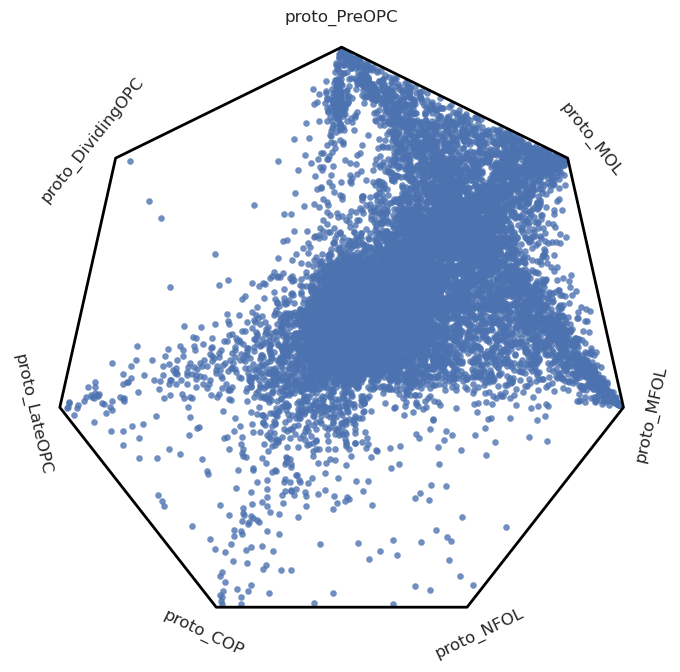

In [74]:
mp.rcParams['savefig.dpi'] = 90
#newcolors = np.array(list(color_dict[cols_MS_all.loc[:,df_in.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba(result.T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[:,0]*0.99, newdata[:,1]*0.99, alpha=0.8,\
           #c=newcolors[:,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_Control_oligo.pdf')

### Scoring NAWM oligo

In [75]:
df_MS_NAWM = df_MS_Oligo.loc[:,cols_MS_all.loc['Lregion_sym']=='NAWM']
#ct_MS_NAWM = cols_MS_all[df_MS_NAWM.columns].loc['Lregion_sym']
#proto_group = proto.loc[ct_MS_NAWM].values
df_in = df_MS_NAWM.loc[df_proto.index].copy()
max_values = df_in.values.max(1)
# Avoid division by zero
max_values[max_values == 0] = 1  # Set to a non-zero value
result = df_in.values / max_values[:, np.newaxis]

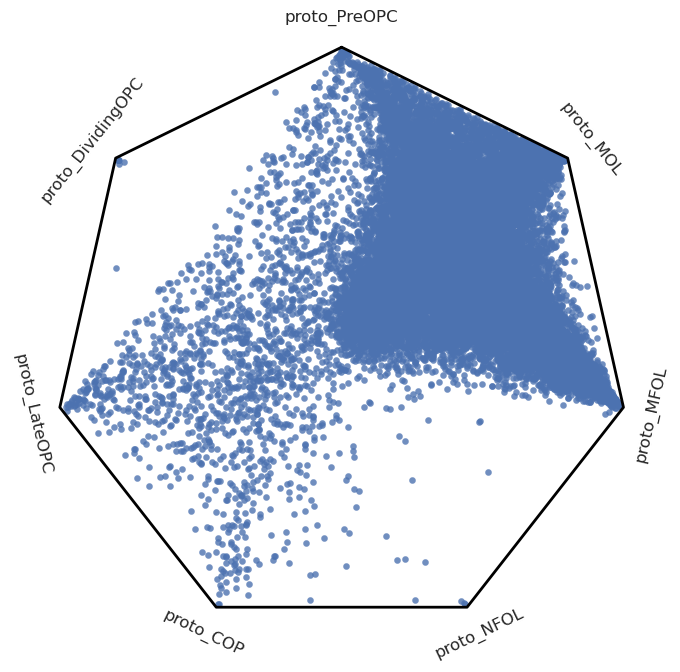

In [76]:
mp.rcParams['savefig.dpi'] = 90
#newcolors = np.array(list(color_dict[cols_MS_all.loc[:,df_in.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba(result.T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[:,0]*0.99, newdata[:,1]*0.99, alpha=0.8,\
           #c=newcolors[:,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_NAWM_oligo.pdf')

### Scoring CA oligo

In [77]:
df_MS_CA = df_MS_Oligo.loc[:,cols_MS_all.loc['Lregion_sym']=='CA']
#ct_MS_CA = cols_MS_all[df_MS_CA.columns].loc['Lregion_sym']
#proto_group = proto.loc[ct_MS_CA].values
df_in = df_MS_CA.loc[df_proto.index].copy()
max_values = df_in.values.max(1)
# Avoid division by zero
max_values[max_values == 0] = 1  # Set to a non-zero value
result = df_in.values / max_values[:, np.newaxis]

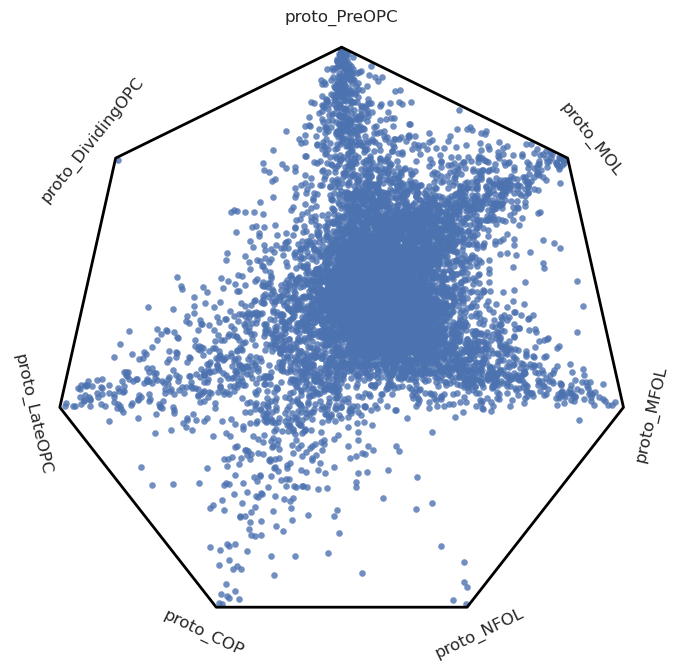

In [78]:
mp.rcParams['savefig.dpi'] = 90
#newcolors = np.array(list(color_dict[cols_MS_all.loc[:,df_in.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba(result.T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[:,0]*0.99, newdata[:,1]*0.99, alpha=0.8,\
           #c=newcolors[:,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_CA_oligo.pdf')

### Scoring CA edge oligo

In [79]:
df_MS_CA_edge = df_MS_Oligo.loc[:,cols_MS_all.loc['Lregion_sym']=='CA edge']
#ct_MS_CA_edge = cols_MS_all[df_MS_CA_edge.columns].loc['Lregion_sym']
#proto_group = proto.loc[ct_MS_CA_edge].values
df_in = df_MS_CA_edge.loc[df_proto.index].copy()
max_values = df_in.values.max(1)
# Avoid division by zero
max_values[max_values == 0] = 1  # Set to a non-zero value
result = df_in.values / max_values[:, np.newaxis]

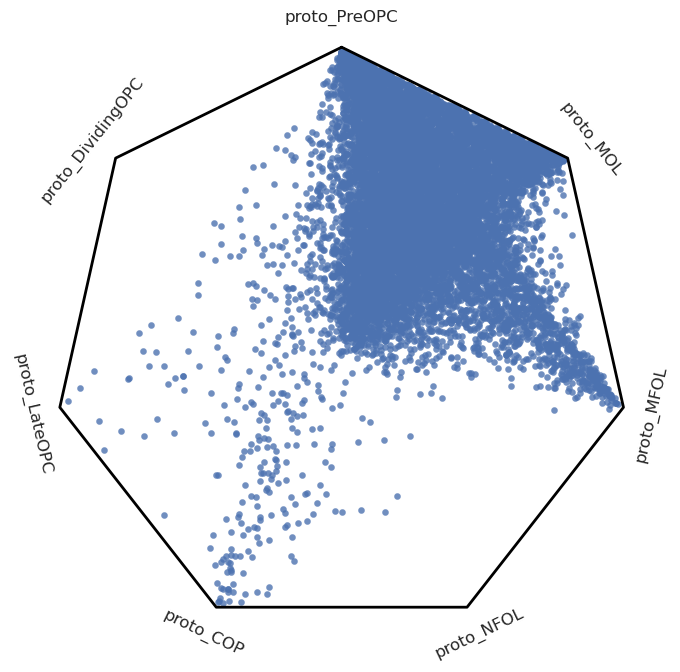

In [80]:
mp.rcParams['savefig.dpi'] = 90
#newcolors = np.array(list(color_dict[cols_MS_all.loc[:,df_in.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba(result.T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[:,0]*0.99, newdata[:,1]*0.99, alpha=0.8,\
           #c=newcolors[:,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_CA_edge_oligo.pdf')

### Scoring CI oligo

In [81]:
df_MS_CI = df_MS_Oligo.loc[:,cols_MS_all.loc['Lregion_sym']=='CI']
#ct_MS_CI = cols_MS_all[df_MS_CI.columns].loc['Lregion_sym']
#proto_group = proto.loc[ct_MS_CI].values
df_in = df_MS_CI.loc[df_proto.index].copy()
max_values = df_in.values.max(1)
# Avoid division by zero
max_values[max_values == 0] = 1  # Set to a non-zero value
result = df_in.values / max_values[:, np.newaxis]

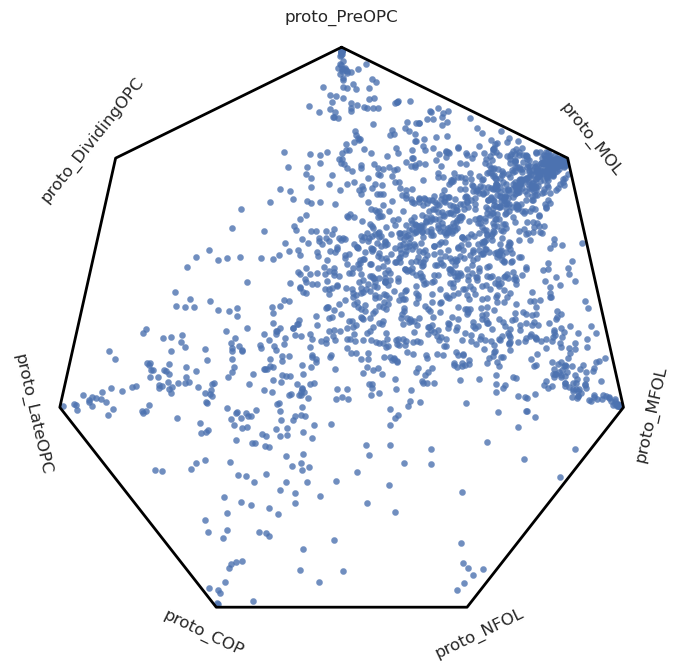

In [82]:
mp.rcParams['savefig.dpi'] = 90
#newcolors = np.array(list(color_dict[cols_MS_all.loc[:,df_in.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba(result.T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[:,0]*0.99, newdata[:,1]*0.99, alpha=0.8,\
           #c=newcolors[:,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_CI_oligo.pdf')

### Scoring CI edge oligo

In [83]:
df_MS_CI_edge = df_MS_Oligo.loc[:,cols_MS_all.loc['Lregion_sym']=='CI edge']
#ct_MS_CI_edge = cols_MS_all[df_MS_CI_edge.columns].loc['Lregion_sym']
#proto_group = proto.loc[ct_MS_CI_edge].values
df_in = df_MS_CI_edge.loc[df_proto.index].copy()
max_values = df_in.values.max(1)
# Avoid division by zero
max_values[max_values == 0] = 1  # Set to a non-zero value
result = df_in.values / max_values[:, np.newaxis]

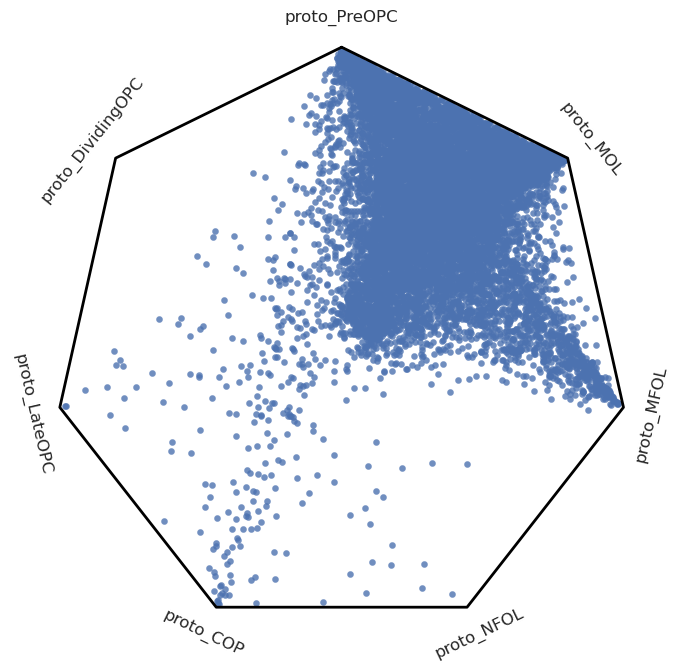

In [84]:
mp.rcParams['savefig.dpi'] = 90
#newcolors = np.array(list(color_dict[cols_MS_all.loc[:,df_in.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba(result.T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[:,0]*0.99, newdata[:,1]*0.99, alpha=0.8,\
           #c=newcolors[:,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_CI_edge_oligo.pdf')

## Calculating and Storing prediction score

In [118]:
# Load MS data
adata = sc.read_h5ad("scRNA_MS_Oligo.h5ad")

In [119]:
predict_names = np.array(['COP', 'Dividing-OPC', 'Late-OPC', 
                          'MFOL', 'MOL', 'NFOL', 'Pre-OPC'])

predict_order = ['Pre-OPC', 'Dividing-OPC', 'Late-OPC', 'COP', 
                'NFOL', 'MFOL', 'MOL',]

order_ix = [list(predict_names).index(i) for i in predict_order]

In [120]:
# Step 1: 计算所有细胞的原型打分
df_MS_Oligo = pd.DataFrame(adata.raw.X.T.A, index=adata.raw.var["_index"], 
                           columns=adata.raw.obs_names)
df_MS_Oligo = df_MS_Oligo.loc[df_proto.index, :]

max_values = df_MS_Oligo.values.max(1)
max_values[max_values == 0] = 1 
normalized_input = df_MS_Oligo.values / max_values[:, np.newaxis]

In [116]:
# Step 2: model prediction
pred_scores = LR.predict_proba(normalized_input.T)

# Create DataFrame to store predicted scores 
df_pred_scores = pd.DataFrame(pred_scores, index=df_MS_Oligo.columns, columns=classes_names[reorder_ix])

# Step 3: Setting similarity score thresholds
adata.obs["Predicted_Celltype"] = df_pred_scores.idxmax(axis=1)  # 选择最高分对应的细胞类型
adata.obs["Max_Pred_Score"] = df_pred_scores.max(axis=1)  # 获取最高分

# Setting P ≥ 0.80 as the cut-off of similarity score for cell type classifications
adata.obs.loc[adata.obs["Max_Pred_Score"] < 0.80, "Predicted_Celltype"] = "Unassigned"

In [ ]:
# Step 2: model prediction
pred_scores = LR.predict_proba(normalized_input.T)

# Create DataFrame to store predicted scores 
df_pred_scores = pd.DataFrame(pred_scores, index=df_MS_Oligo.columns, columns=predict_names[order_ix])

# Step 3: Setting similarity score thresholds
adata.obs["Predicted_Celltype"] = df_pred_scores.idxmax(axis=1)
adata.obs["Max_Pred_Score"] = df_pred_scores.max(axis=1)

# Setting P ≥ 0.85 as the cut-off of similarity score for cell type classifications
adata.obs.loc[adata.obs["Max_Pred_Score"] < 0.70, "Predicted_Celltype"] = "Unassigned"

In [123]:
adata.obs['Predicted_Celltype'].value_counts()

Unassigned      68189
COP              3582
MOL              1055
NFOL              701
Late-OPC          196
Pre-OPC            75
MFOL               14
Dividing-OPC       10
Name: Predicted_Celltype, dtype: int64

In [96]:
if "_index" in adata.var.columns:
    adata.var.rename(columns={"_index": "gene_name"}, inplace=True)

In [111]:
adata.obs["Predicted_Celltype"] = adata.obs["Predicted_Celltype"].astype("category")

In [ ]:
# Save the predicted cell types
adata.obs[['Predicted_Celltype']].to_csv("HigFidCelProtoScoringMS/Predicted_Celltype.csv")

In [73]:
df_MS_Control = df_MS_Oligo.loc[:,cols_MS_all.loc['Lregion_sym']=='Control']
df_in = df_MS_Control.loc[df_proto.index].copy()
max_values = df_in.values.max(1)
# Avoid division by zero
max_values[max_values == 0] = 1  # Set to a non-zero value
result = df_in.values / max_values[:, np.newaxis]

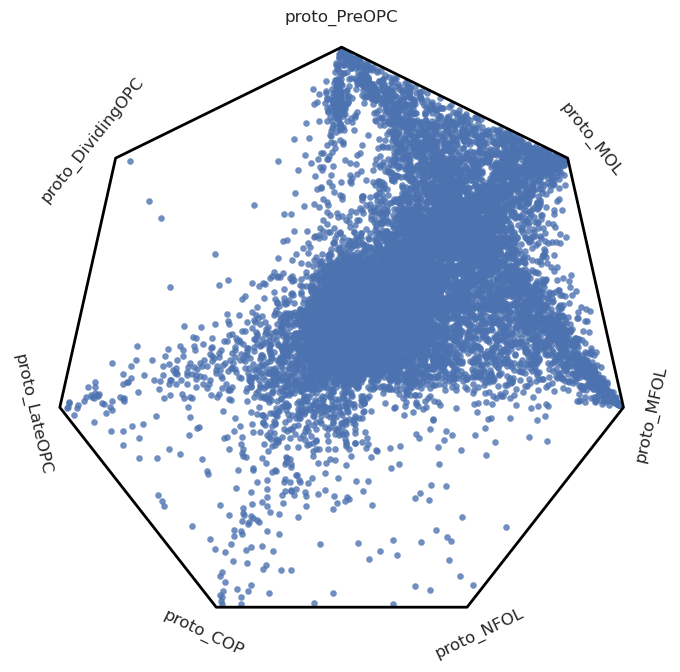

In [74]:
mp.rcParams['savefig.dpi'] = 90
#newcolors = np.array(list(color_dict[cols_MS_all.loc[:,df_in.columns].loc['Prototype']].values))

newdata,ax = polygonalPlot(LR.predict_proba(result.T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[:,0]*0.99, newdata[:,1]*0.99, alpha=0.8,\
           #c=newcolors[:,:],\
           s =20, lw=0.2)
mp.savefig(r'HigFidCelProtoScoringMS/Wheel_plot_Control_oligo.pdf')